In [155]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession

from pyspark.sql import Window
from pyspark.sql.functions import countDistinct, collect_list, collect_set, create_map, col, mean, avg, row_number, desc, udf, count, lit, array_intersect, size, rank, concat, array, sum, abs, when


In [5]:
spark = SparkSession.builder.master("local[4]") \
                    .appName('recommendation_system') \
                    .config("spark.driver.memory", "15g") \
                    .getOrCreate()

In [6]:
df = spark.read.options(
            header=True,
            inferSchema=True
        ) \
        .csv('data/ratings_processed.csv')

In [7]:
print(f"The unique number of users is {df.select(countDistinct('userId')).collect()[0][0]}\n"
      f"User ID starts from {df.agg({'userId': 'min'}).collect()[0][0]}\n"
      f"User ID ends at {df.agg({'userId': 'max'}).collect()[0][0]}"
)

The unique number of users is 2000
User ID starts from 0
User ID ends at 1999


In [8]:
print(f"The unique number of movies is {df.select(countDistinct('movieId')).collect()[0][0]}\n"
      f"Movie ID starts from {df.agg({'movieId': 'min'}).collect()[0][0]}\n"
      f"Movie ID ends at {df.agg({'movieId': 'max'}).collect()[0][0]}"
)

The unique number of movies is 500
Movie ID starts from 0
Movie ID ends at 499


In [9]:
N = df.agg({'userId': 'max'}).collect()[0][0]
M = df.agg({'movieId': 'max'}).collect()[0][0]

In [10]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [11]:
print(
    f"The number of samples in training data is {train_data.count()}\n"
    f"The number of samples in test data is {test_data.count()}"
)

The number of samples in training data is 542114
The number of samples in test data is 135415


In [12]:
train_data.printSchema()

root
 |-- rating: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)



### Checking if the entries of all users and movies are present in both train and test set

In [13]:
print(
    f"The number of users in training set is {train_data.select(countDistinct('userId')).collect()[0][0]}\n"
    f"The number of users in test set is {test_data.select(countDistinct('userId')).collect()[0][0]}\n"
    f"The number of movies in training set is {train_data.select(countDistinct('movieId')).collect()[0][0]}\n"
    f"The number of movies in test set is {test_data.select(countDistinct('movieId')).collect()[0][0]}\n"
)

The number of users in training set is 2000
The number of users in test set is 2000
The number of movies in training set is 500
The number of movies in test set is 500



### Distribution of movies in training and test data

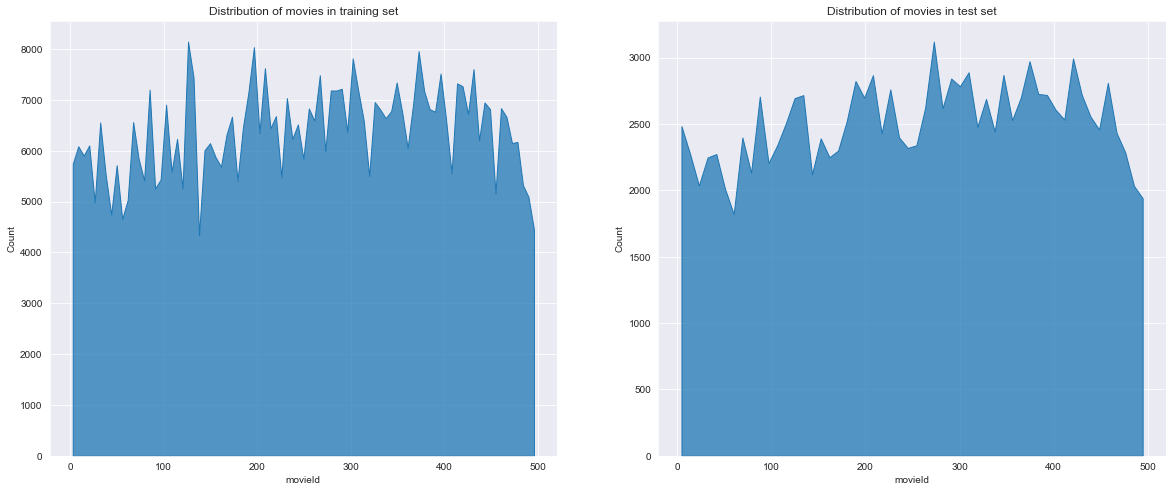

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(
    data = train_data.toPandas(),
    x = 'movieId',
    element='poly',
    ax =axs[0]
)

axs[0].set_title('Distribution of movies in training set')
sns.histplot(
    data = test_data.toPandas(),
    x = 'movieId',
    element='poly',
    ax =axs[1]
)
axs[1].set_title('Distribution of movies in test set')
plt.show()

In [219]:
train_data.printSchema()

root
 |-- rating: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)



In [220]:
## Find sigma value
def find_sigma(dev_list):
    arr = np.array(dev_list)
    result = np.sqrt(arr.dot(arr))
    return int(result)

In [221]:
from pyspark.sql import types as T
find_sigma_udf = udf(find_sigma, T.IntegerType())

window = Window.partitionBy('userId').orderBy('rating')
windowAgg = Window.partitionBy('userId')

summarised_train_data = train_data \
    .withColumn("row", row_number().over(window)) \
    .withColumn("avg", avg(col("rating")).over(windowAgg)) \
    .withColumn("deviation", col('rating') - col('avg')) \
    .withColumn("sigma", find_sigma_udf(collect_list(col('deviation')).over(windowAgg))) \
    .withColumn("calculations", create_map(
        lit("avg"), col("avg"),
        lit("sigma"), col("sigma"),
        col("movieId"), col("deviation"),
        )) \
    .withColumn("movies", collect_set(col('movieId')).over(windowAgg)) \
    .select('userId', 'movies', 'calculations') \
    .rdd \
    .map(lambda row: ((row[0], tuple(row[1])), row[2])) \
    .reduceByKey(lambda a, b: {**a, **b}) \
    .map(lambda row: (row[0][0], list(row[0][1]), row[1])) \
    .toDF(["userId", "movies", "calculations"]) \
    .orderBy('userId')


AssertionError: 

In [115]:
summarised_train_data.show()

+------+--------------------+--------------------+
|userId|              movies|        calculations|
+------+--------------------+--------------------+
|     0|[364, 356, 212, 1...|{191 -> 0.8963414...|
|     1|[0, 356, 306, 387...|{471 -> -0.161290...|
|     2|[0, 387, 277, 256...|{350 -> 0.8489208...|
|     3|[0, 356, 466, 306...|{230 -> 0.8745019...|
|     4|[0, 306, 387, 277...|{350 -> 0.5394190...|
|     5|[466, 356, 387, 2...|{350 -> -0.295275...|
|     6|[466, 356, 306, 1...|{471 -> 0.5919282...|
|     7|[466, 0, 306, 2, ...|{471 -> 0.1887254...|
|     8|[306, 387, 277, 2...|{350 -> 0.0540069...|
|     9|[0, 356, 466, 437...|{471 -> 0.0988593...|
|    10|[466, 356, 212, 3...|{230 -> 0.765625,...|
|    11|[0, 356, 387, 256...|{350 -> 0.65625, ...|
|    12|[306, 387, 227, 2...|{470 -> -0.100378...|
|    13|[466, 437, 306, 3...|{470 -> -0.777173...|
|    14|[0, 466, 356, 387...|{470 -> 1.3665480...|
|    15|[356, 306, 277, 2...|{350 -> -0.314199...|
|    16|[0, 466, 102, 306...|{3

In [19]:
summarised_train_data.count()

2000

In [20]:
K = 25
limit = 5

In [21]:
def calculate_weight(calculations_i, calculations_j, common_movies):
    numerator = 0
    for movieId in common_movies:
        numerator += calculations_i[str(movieId)] * calculations_j[str(movieId)]

    return numerator / ( calculations_i['sigma'] * calculations_j['sigma'] )

In [99]:

windowAgg = Window.partitionBy("user_i").orderBy(desc("weight"))

calculate_weight_udf = udf(calculate_weight, T.FloatType())

weight_data = summarised_train_data \
    .select(
        col('userId').alias('user_i'),
        col('movies').alias('movies_i'),
        col('calculations').alias('calculations_i')
    ) \
    .crossJoin(summarised_train_data
               .select(
                        col('userId').alias('user_j'),
                        col('movies').alias('movies_j'),
                        col('calculations').alias('calculations_j'),
                    )
               ) \
    .filter(col('user_i') != col('user_j')) \
    .withColumn(
                "common_movies", array_intersect(col('movies_i'), col('movies_j'))
                ) \
    .withColumn(
                "weight", calculate_weight_udf(
                                    col("calculations_i"),
                                    col("calculations_j"),
                                    col("common_movies"),
                                )
    ) \
    .drop("movies_i", "movies_j", "calculations_i", "calculations_j", "common_movies") \
    .withColumn("weight_ij", create_map(
        col('user_j'), col("weight"),
        )) \
    .withColumn("row", row_number().over(windowAgg)) \
    .orderBy(col("user_i"), col("weight").desc()) \
    .drop("user_j") \
    .filter(col("row") <= K).drop("row")
    # .rdd \
    # .map(lambda row: (row[0], row[2])).reduceByKey(lambda a, b: {**a, **b}) \
    # .map(lambda row:
    #          (
    #              row[0],
    #               [
    #                   {k: float(v) for k, v in [('neighbor', neighbor), ('weight', weight)]}
    #                   for neighbor, weight in sorted(row[1].items(), key=lambda item: item[1], reverse=True)
    #               ]
    #          )
    #      ) \
    # .toDF(["user", "neighbors_weight"])


In [108]:

windowAgg = Window.partitionBy("user_i").orderBy(desc("weight"))

calculate_weight_udf = udf(calculate_weight, T.FloatType())

weight_data = summarised_train_data \
    .select(
        col('userId').alias('user_i'),
        col('movies').alias('movies_i'),
        col('calculations').alias('calculations_i')
    ) \
    .crossJoin(summarised_train_data
               .select(
                        col('userId').alias('user_j'),
                        col('movies').alias('movies_j'),
                        col('calculations').alias('calculations_j'),
                    )
               ) \
    .filter(col('user_i') != col('user_j')) \
    .withColumn(
                "common_movies", array_intersect(col('movies_i'), col('movies_j'))
                ) \
    .withColumn(
                "weight", calculate_weight_udf(
                                    col("calculations_i"),
                                    col("calculations_j"),
                                    col("common_movies"),
                                )
    ) \
    .drop("movies_i", "movies_j", "common_movies") \
    .withColumn("row", row_number().over(windowAgg)) \
    .filter(col("row") <= K).drop("row")
    # .rdd \
    # .map(lambda row: (row[0], row[2])).reduceByKey(lambda a, b: {**a, **b}) \
    # .map(lambda row:
    #          (
    #              row[0],
    #               [
    #                   {k: float(v) for k, v in [('neighbor', neighbor), ('weight', weight)]}
    #                   for neighbor, weight in sorted(row[1].items(), key=lambda item: item[1], reverse=True)
    #               ]
    #          )
    #      ) \
    # .toDF(["user", "neighbors_weight"])


In [109]:
weight_data.show()

+------+--------------------+------+--------------------+----------+
|user_i|      calculations_i|user_j|      calculations_j|    weight|
+------+--------------------+------+--------------------+----------+
|    26|{470 -> -0.052478...|  1989|{470 -> 0.0944148...|0.44695708|
|    26|{470 -> -0.052478...|  1013|{350 -> 0.1464435...| 0.4464242|
|    26|{470 -> -0.052478...|  1451|{471 -> 1.6782178...|0.44227955|
|    26|{470 -> -0.052478...|  1306|{471 -> -0.263297...|0.43343735|
|    26|{470 -> -0.052478...|  1081|{470 -> 0.7353801...|0.43270737|
|    26|{470 -> -0.052478...|  1300|{0 -> 0.779448621...|0.43129292|
|    26|{470 -> -0.052478...|   973|{470 -> 0.1521164...|0.42491606|
|    26|{470 -> -0.052478...|  1191|{350 -> -0.886435...|0.41981676|
|    26|{470 -> -0.052478...|   827|{470 -> -0.373437...|0.41726848|
|    26|{470 -> -0.052478...|  1571|{470 -> 0.6873111...|0.41580778|
|    26|{470 -> -0.052478...|   322|{350 -> -0.496282...|  0.414136|
|    26|{470 -> -0.052478...|  185

In [33]:
weight_data.write.json('./data/user_weights.json')

In [4]:
weight_data = spark.read.json('./data/user_weights.json')
weight_data = weight_data.select('user', 'neighbors_weight')

### Evaluating Training Dataset

In [150]:
train_data.count()

542114

In [203]:
window = Window.partitionBy('user_i', 'movieId')
windowAgg = Window.partitionBy('user_i', 'movieId').orderBy("userId", "movieId")

train_predictions = train_data.join(weight_data,train_data.userId == weight_data.user_i, "inner").drop('user_Id') \
    .withColumn("weighted_deviation", col('weight') * col('calculations_j')[col('movieId')]) \
    .filter(col('weighted_deviation').isNotNull()) \
    .withColumn("numerator", sum(col('weighted_deviation')).over(window) ) \
    .withColumn("denominator", sum(abs(col('weight'))).over(window) ) \
    .withColumn("prediction", col("numerator") / col("denominator") + col('calculations_i')['avg']) \
    .withColumn("row", row_number().over(windowAgg)) \
    .filter(col("row") == 1).drop("row") \
    .select("userId", "movieId", "rating", "prediction")

In [204]:
train_predictions.show(10)

+------+-------+------+------------------+
|userId|movieId|rating|        prediction|
+------+-------+------+------------------+
|    26|      1|   3.0|2.8028858092072486|
|    26|      3|   3.0|2.2921321351116397|
|    26|      5|   4.0| 2.906995424047466|
|    26|      7|   4.0|3.6171285312119656|
|    26|      9|   4.0|3.7289351139936238|
|    26|     10|   2.0|1.6293744869676965|
|    26|     11|   3.0| 3.548868593404618|
|    26|     12|   3.5| 3.075381112122394|
|    26|     14|   3.0|2.6019674150897845|
|    26|     15|   3.5| 4.019432460521232|
+------+-------+------+------------------+
only showing top 10 rows



In [208]:
train_predictions \
    .withColumn('error', (col('prediction') - col('rating')) * (col('prediction') - col('rating'))) \
    .select(mean(col('error'))) \
    .collect()[0][0]

0.5198600159527748

### Evaluating Test Dataset

In [209]:
test_data.count()

135415

In [210]:
test_data.printSchema()

root
 |-- rating: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)



In [212]:
window = Window.partitionBy('user_i', 'movieId')
windowAgg = Window.partitionBy('user_i', 'movieId').orderBy("userId", "movieId")

test_predictions = test_data.join(weight_data,test_data.userId == weight_data.user_i, "inner").drop('user_Id') \
    .withColumn("weighted_deviation", col('weight') * col('calculations_j')[col('movieId')]) \
    .filter(col('weighted_deviation').isNotNull()) \
    .withColumn("numerator", sum(col('weighted_deviation')).over(window) ) \
    .withColumn("denominator", sum(abs(col('weight'))).over(window) ) \
    .withColumn("prediction", col("numerator") / col("denominator") + col('calculations_i')['avg']) \
    .withColumn("row", row_number().over(windowAgg)) \
    .filter(col("row") == 1).drop("row") \
    .select("userId", "movieId", "rating", "prediction")

In [213]:
test_predictions \
    .withColumn('error', (col('prediction') - col('rating')) * (col('prediction') - col('rating'))) \
    .select(mean(col('error'))) \
    .collect()[0][0]

0.6041636794516598

In [ ]:
# edges = weight_data.rdd.map(lambda row: (1, [(row[0], int(d['neighbor']), d['weight']) for d in row[1]]) if row[0] < 100 else (1, [])).flatMap(lambda row: row[1]).collect()

In [214]:
# G = nx.Graph()
# G.add_weighted_edges_from(edges_test)
# plt.figure(num=None, figsize=(30, 20), dpi=80)
# plt.figure(num=None, figsize=(30, 20), dpi=80)
#
# pos = nx.spring_layout(G, k=0.5, iterations=50)
# # nx.draw(G, node_size=350, font_size='large', with_labels=True, pos=pos)
# nx.draw_networkx_nodes(G,pos, node_size=350, node_color='#6D9886')
# nx.draw_networkx_edges(G,pos, edge_color='#393E46')
# nx.draw_networkx_labels(G,pos, font_size='larger')
# plt.axis('off')
# plt.savefig('./images/users_relationship.png')
# plt.show()

In [215]:

# G = nx.Graph()
# G.add_weighted_edges_from(edges)
# plt.figure(num=None, figsize=(30, 20), dpi=80)
#
# pos = nx.spring_layout(G, k=0.4, iterations=20)
# # nx.draw(G, node_size=350, font_size='large', with_labels=True, pos=pos)
# nx.draw_networkx_nodes(G,pos, node_size=70, node_color='#6D9886')
# nx.draw_networkx_edges(G,pos, edge_color='#393E46')
# plt.axis('off')
# # plt.savefig('./images/users_relationship.png')
# plt.show()

In [216]:
spark.stop()